# Let's code a Neural Network in plain NumPy
---

***Author: Piotr Skalski***

Using high-level frameworks like Keras, TensorFlow or PyTorch allows us to build very complex models quickly. However, it is worth taking the time to look inside and understand underlying concepts. This time we will try to make use of our knowledge and build a fully operational neural network using only NumPy. Finally, we will also use it to solve simple classification problems and compare its performance with the model built with Keras.

## Imports

In [2]:
import numpy as np
from IPython.display import Image

## Network architecture

![Network architecture](./supporting_visualizations/nn_architecture.png)

<b>Figure 1.</b> Example of dense neural network architecture

## First things first

Before we start programming, let's stop for a moment and prepare a basic roadmap. Our goal is to create a program capable of creating a densely connected neural network with the specified architecture (number and size of layers and appropriate activation function). An example of such a network is presented in Figure 1. Above all, we must be able to train our network and make predictions using it.

![Roadmap](./supporting_visualizations/blueprint.gif)

<b>Figure 2.</b> Neural network blueprint

Diagram above shows what operations will have to be performed during the training of our neural network. It also shows how many parameters we will have to update and read at different stages of a single iteration. Building the right data structure and skillfully managing its state is the most difficult part of our task.

## Initiation of neural network layers

![Parameters sizes](./supporting_visualizations/params_sizes.png)

<b>Figure 3.</b> Dimensions of weight matrix W and bias vector b for layer l.

Let's start with by initiating weight matrix W and bias vector b for each layer. In Figure 3 I have prepared a small cheatsheet, which will help us to asign the appropriate dimensions for these coefficients. Superscript [l] denotes the index of the current layer (counted from 1). I assumed that the information describing the NN architecture will be delivered to our program in the form of list. Each item in the list is a dictionary describing the basic parameters of a single network layer: input_dim - the size of the signal vector supplied as an input for the layer, output_dim - the size of the activation vector obtained at the output of the layer and activation - the activation function to be used inside the layer.

In [3]:
NN_ARCHITECTURE = [
    {"input_dim": 2, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 50, "activation": "relu"},
    {"input_dim": 50, "output_dim": 25, "activation": "relu"},
    {"input_dim": 25, "output_dim": 1, "activation": "sigmoid"},
]

## Initiation of parameter values for each layer

Let's finally focus on the main task that we have to accomplish in this part - the initiation of layers parameters. Initial weights values cannot be equal because it leads to breaking symmetry problem. Basically, if all weights are the same, no matter what was the input X, all units in hidden layer will be the same too. In a way, we got stuck in the initial state without any hope for escape, no matter how long will we train our model and how deep our network is. The use of small values increases the efficiency of our algorithm during first iterations. Looking at the graph of the sigmoid function, shown in Figure 4, we can see that it reaches the highest derivative value for numbers close to zero, which has significant effect on the speed of learning of our NN. All in all parameter initiation using small random numbers is simple approach, but it guarantees good enough starting point for out algorithm. Prepared parameters values are stored in a python dictionary with a key that uniquely identifies to which layer they belong. The dictionary is returned at the end of the function, so we can use it in the next stages of our algorithm.

In [4]:
def init_layers(nn_architecture, seed = 99):
    # random seed initiation
    np.random.seed(seed)
    # number of layers in our neural network
    number_of_layers = len(nn_architecture)
    # parameters storage initiation
    params_values = {}
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        # extracting the number of units in layers
        layer_input_size = layer["input_dim"]
        layer_output_size = layer["output_dim"]
        
        # initiating the values of the W matrix
        # and vector b for subsequent layers
        params_values['W' + str(layer_idx)] = np.random.randn(
            layer_output_size, layer_input_size) * 0.1
        params_values['b' + str(layer_idx)] = np.random.randn(
            layer_output_size, 1) * 0.1
        
    return params_values

## Activation functions

Amongst all the functions that we will use today, there are a few very simple but powerful ones. Activation functions can be written in a single line of code, but they give the neural nets non-linearity and therefore the expressiveness that they need. "Without them, our neural network would become a combination of linear functions, so it would be just a linear function itself." There are many activation functions, but in this project I decided to provide the possibility of using two of them - sigmoid and ReLU. We also have to prepare their derivatives in order to be able to go full circle and pass both forward and backward propagation.

![Activations](./supporting_visualizations/activations.gif)

<b>Figure 4.</b> Activation functions used in the algorithm.

In [5]:
def sigmoid(Z):
    return 1/(1+np.exp(-Z))

def relu(Z):
    return np.maximum(0,Z)

def sigmoid_backward(dA, Z):
    sig = sigmoid(Z)
    return dA * sig * (1 - sig)

def relu_backward(dA, Z):
    dZ = np.array(dA, copy = True)
    dZ[Z <= 0] = 0;
    return dZ;

## Single layer forward propagation step

This part of the code is probably the most straightforward and easy to understand . Given input signal from previous layer, we compute affine transformation Z and then apply selected activation function. By using NumPy, we can leverage vectorization - performing matrix operations, for whole layer and whole batch of examples at once. This eliminates iteration and significantly speeds up our calculations. In addition to the calculated matrix A, our function also returns an intermediate value of Z. What for? The answer is shown in Figure 2. We will need Z during the backward step.

$$\boldsymbol{Z}^{[l]} = \boldsymbol{W}^{[l]} \cdot \boldsymbol{A}^{[l-1]} + \boldsymbol{b}^{[l]}$$

$$\boldsymbol{A}^{[l]} = g^{[l]}(\boldsymbol{Z}^{[l]})$$

In [6]:
def single_layer_forward_propagation(A_prev, W_curr, b_curr, activation="relu"):
    # calculation of the input value for the activation function
    Z_curr = np.dot(W_curr, A_prev) + b_curr
    
    # selection of activation function
    if activation is "relu":
        activation_func = relu
    elif activation is "sigmoid":
        activation_func = sigmoid
    else:
        raise Exception('Non-supported activation function')
        
    # return of calculated activation A and the intermediate Z matrix
    return activation_func(Z_curr), Z_curr

![Matrix sizes 2](./supporting_visualizations/matrix_sizes_2.png)

## Full forward propagation

With the single_layer_forward_propagation function completed, we can easily build a whole step forward. This is a slightly more complex function, whose role is not only to perform predictions but also to organize the collection of intermediate values.

In [7]:
def full_forward_propagation(X, params_values, nn_architecture):
    # creating a temporary memory to store the information needed for a backward step
    memory = {}
    # X vector is the activation for layer 0 
    A_curr = X
    
    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        # transfer the activation from the previous iteration
        A_prev = A_curr
        
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        # extraction of W for the current layer
        W_curr = params_values["W" + str(layer_idx)]
        # extraction of b for the current layer
        b_curr = params_values["b" + str(layer_idx)]
        # calculation of activation for the current layer
        A_curr, Z_curr = single_layer_forward_propagation(A_prev, W_curr, b_curr, activ_function_curr)
        
        # saving calculated values in the memory
        memory["A" + str(idx)] = A_prev
        memory["Z" + str(layer_idx)] = Z_curr
       
    # return of prediction vector and a dictionary containing intermediate values
    return A_curr, memory

## Calculating cost

In order to monitor our progress and make sure that we are moving in desired direction, we should routinely calculate the value of the loss function. "Generally speaking, the loss function is designed to show how far we are from the 'ideal' solution." It is selected according to the problem we plan to solve, and frameworks such as Keras have many options to choose from. Because I am planning to test our NN for the classification of points between two classes, I decided to use binary crossentropy, which is defined by the following formulas. In order to give us more information on how our neural network is coping with the task, I have also decided to implement a function that will calculate accuracy for us.

![Cost Function](./supporting_visualizations/cost_function.gif)

In [8]:
def get_cost_value(Y_hat, Y):
    # number of examples
    m = Y_hat.shape[1]
    # calculation of the cost according to the formula
    cost = -1 / m * (np.dot(Y, np.log(Y_hat).T) + np.dot(1 - Y, np.log(1 - Y_hat).T))
    return np.squeeze(cost)

## Calculating accuracy

In [9]:
# an auxiliary function that converts probability into class
def convert_prob_into_class(probs):
    probs_ = np.copy(probs)
    probs_[probs_ > 0.5] = 1
    probs_[probs_ <= 0.5] = 0
    return probs_

In [10]:
def get_accuracy_value(Y_hat, Y):
    Y_hat_ = convert_prob_into_class(Y_hat)
    return (Y_hat_ == Y).all(axis=0).mean()

## Single layer backward propagation step

$$\frac{\partial L }{\partial \boldsymbol{\hat{Y}}} = -(\frac{\boldsymbol{Y}}{\boldsymbol{\hat{Y}}}- \frac{1-\boldsymbol{Y}}{1-\boldsymbol{\hat{Y}}})$$

In [11]:
def single_layer_backward_propagation(dA_curr, W_curr, b_curr, Z_curr, A_prev, activation="relu"):
    # number of examples
    m = A_prev.shape[1]
    
    # selection of activation function
    if activation is "relu":
        backward_activation_func = relu_backward
    elif activation is "sigmoid":
        backward_activation_func = sigmoid_backward
    else:
        raise Exception('Non-supported activation function')
    
    # calculation of the activation function derivative
    dZ_curr = backward_activation_func(dA_curr, Z_curr)
    
    # derivative of the matrix W
    dW_curr = np.dot(dZ_curr, A_prev.T) / m
    # derivative of the vector b
    db_curr = np.sum(dZ_curr, axis=1, keepdims=True) / m
    # derivative of the matrix A_prev
    dA_prev = np.dot(W_curr.T, dZ_curr)

    return dA_prev, dW_curr, db_curr

## Full backward propagation

$$\boldsymbol{dW}^{[l]} = \frac{\partial L }{\partial \boldsymbol{W}^{[l]}} = \frac{1}{m} \boldsymbol{dZ}^{[l]} \boldsymbol{A}^{[l-1] T}$$

$$\boldsymbol{db}^{[l]} = \frac{\partial L }{\partial \boldsymbol{b}^{[l]}} = \frac{1}{m} \sum_{i = 1}^{m} \boldsymbol{dZ}^{[l](i)}$$

$$\boldsymbol{dA}^{[l-1]} = \frac{\partial L }{\partial \boldsymbol{A}^{[l-1]}} = \boldsymbol{W}^{[l] T} \boldsymbol{dZ}^{[l]}$$

$$\boldsymbol{dZ}^{[l]} = \boldsymbol{dA}^{[l]} * g'(\boldsymbol{Z}^{[l]})$$

In [12]:
def full_backward_propagation(Y_hat, Y, memory, params_values, nn_architecture):
    grads_values = {}
    
    # number of examples
    m = Y.shape[1]
    # a hack ensuring the same shape of the prediction vector and labels vector
    Y = Y.reshape(Y_hat.shape)
    
    # initiation of gradient descent algorithm
    dA_prev = - (np.divide(Y, Y_hat) - np.divide(1 - Y, 1 - Y_hat));
    
    for layer_idx_prev, layer in reversed(list(enumerate(nn_architecture))):
        # we number network layers from 1
        layer_idx_curr = layer_idx_prev + 1
        # extraction of the activation function for the current layer
        activ_function_curr = layer["activation"]
        
        dA_curr = dA_prev
        
        A_prev = memory["A" + str(layer_idx_prev)]
        Z_curr = memory["Z" + str(layer_idx_curr)]
        
        W_curr = params_values["W" + str(layer_idx_curr)]
        b_curr = params_values["b" + str(layer_idx_curr)]
        
        dA_prev, dW_curr, db_curr = single_layer_backward_propagation(
            dA_curr, W_curr, b_curr, Z_curr, A_prev, activ_function_curr)
        
        grads_values["dW" + str(layer_idx_curr)] = dW_curr
        grads_values["db" + str(layer_idx_curr)] = db_curr
    
    return grads_values

## Updating parameter values

In [13]:
def update(params_values, grads_values, nn_architecture, learning_rate):

    # iteration over network layers
    for idx, layer in enumerate(nn_architecture):
        # we number network layers from 1
        layer_idx = idx + 1
        
        params_values["W" + str(layer_idx)] -= learning_rate * grads_values["dW" + str(layer_idx)]        
        params_values["b" + str(layer_idx)] -= learning_rate * grads_values["db" + str(layer_idx)]

    return params_values;

## Putting things together

In [104]:
def train(X, Y, nn_architecture, epochs, learning_rate, callback=None):
    # initiation of neural net parameters
    params_values = init_layers(nn_architecture, 2)
    # initiation of lists storing the history 
    # of metrics calculated during the learning process 
    cost_history = []
    accuracy_history = []
    
    # performing calculations for subsequent iterations
    for i in range(epochs):
        # step forward
        Y_hat, cashe = full_forward_propagation(X, params_values, nn_architecture)
        
        # calculating metrics and saving them in history
        cost = get_cost_value(Y_hat, Y)
        cost_history.append(cost)
        accuracy = get_accuracy_value(Y_hat, Y)
        accuracy_history.append(accuracy)
        
        # step backward - calculating gradient
        grads_values = full_backward_propagation(Y_hat, Y, cashe, params_values, nn_architecture)
        # updating model state
        params_values = update(params_values, grads_values, nn_architecture, learning_rate)
        
        if(i % 50 == 0):
            print("Iteration: {:05} - cost: {:.5f} - accuracy: {:.5f}".format(i, cost, accuracy))
            if(callback is not None):
                callback(i, params_values)
            
    return params_values

## David vs Goliath

### Imports

In [89]:
import os
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
sns.set_style("whitegrid")

import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.utils import np_utils
from keras import regularizers

from sklearn.metrics import accuracy_score

### Settings

In [34]:
# number of samples in the data set
N_SAMPLES = 1000
# ratio between training and test sets
TEST_SIZE = 0.1

### Create artificial dataset

In [35]:
X, y = make_moons(n_samples = N_SAMPLES, noise=0.2, random_state=100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE, random_state=42)

### Auxiliary plotting function

In [36]:
# the function making up the graph of a dataset
def make_plot(X, y, plot_name, file_name=None, XX=None, YY=None, preds=None):
    plt.figure(figsize=(10,10))
    sns.set_style("whitegrid")
    axes = plt.gca()
    axes.set(xlabel="$X_1$", ylabel="$X_2$")
    plt.title(plot_name, fontsize=30)
    if(XX is not None and YY is not None and preds is not None):
        plt.contourf(XX, YY, preds.reshape(XX.shape), 25, alpha = 0.6, cmap=cm.Spectral)
        plt.contour(XX, YY, preds.reshape(XX.shape), levels=[.5], cmap="Greys", vmin=0, vmax=.6)
    plt.scatter(X[:, 0], X[:, 1], c=y.ravel(), s=40, cmap=plt.cm.Spectral, edgecolors='black')
    if(file_name):
        plt.savefig(file_name)
        plt.close()

### Visualization of the data set

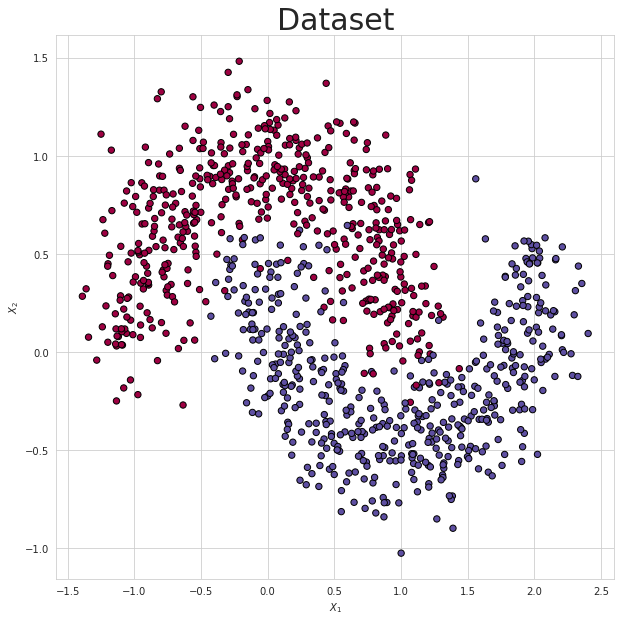

In [37]:
make_plot(X, y, "Dataset")

### Let's put our model to the test

In [105]:
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01)

Iteration: 00000 - cost: 0.69365 - accuracy: 0.50444
Iteration: 00050 - cost: 0.69349 - accuracy: 0.50444
Iteration: 00100 - cost: 0.69334 - accuracy: 0.50444
Iteration: 00150 - cost: 0.69319 - accuracy: 0.50444
Iteration: 00200 - cost: 0.69307 - accuracy: 0.50444
Iteration: 00250 - cost: 0.69295 - accuracy: 0.50444
Iteration: 00300 - cost: 0.69284 - accuracy: 0.50444
Iteration: 00350 - cost: 0.69272 - accuracy: 0.50444
Iteration: 00400 - cost: 0.69260 - accuracy: 0.50444
Iteration: 00450 - cost: 0.69249 - accuracy: 0.50444
Iteration: 00500 - cost: 0.69238 - accuracy: 0.50444
Iteration: 00550 - cost: 0.69228 - accuracy: 0.50444
Iteration: 00600 - cost: 0.69217 - accuracy: 0.50444
Iteration: 00650 - cost: 0.69206 - accuracy: 0.50444
Iteration: 00700 - cost: 0.69194 - accuracy: 0.50444
Iteration: 00750 - cost: 0.69182 - accuracy: 0.50444
Iteration: 00800 - cost: 0.69170 - accuracy: 0.50444
Iteration: 00850 - cost: 0.69156 - accuracy: 0.50444
Iteration: 00900 - cost: 0.69142 - accuracy: 0

Iteration: 07750 - cost: 0.08707 - accuracy: 0.96667
Iteration: 07800 - cost: 0.08647 - accuracy: 0.96778
Iteration: 07850 - cost: 0.08594 - accuracy: 0.96667
Iteration: 07900 - cost: 0.08544 - accuracy: 0.96667
Iteration: 07950 - cost: 0.08497 - accuracy: 0.96667
Iteration: 08000 - cost: 0.08453 - accuracy: 0.96556
Iteration: 08050 - cost: 0.08412 - accuracy: 0.96667
Iteration: 08100 - cost: 0.08371 - accuracy: 0.96667
Iteration: 08150 - cost: 0.08332 - accuracy: 0.96889
Iteration: 08200 - cost: 0.08295 - accuracy: 0.96889
Iteration: 08250 - cost: 0.08259 - accuracy: 0.96889
Iteration: 08300 - cost: 0.08219 - accuracy: 0.96889
Iteration: 08350 - cost: 0.08180 - accuracy: 0.96778
Iteration: 08400 - cost: 0.08145 - accuracy: 0.96778
Iteration: 08450 - cost: 0.08114 - accuracy: 0.96778
Iteration: 08500 - cost: 0.08084 - accuracy: 0.96889
Iteration: 08550 - cost: 0.08055 - accuracy: 0.96889
Iteration: 08600 - cost: 0.08025 - accuracy: 0.97000
Iteration: 08650 - cost: 0.07996 - accuracy: 0

In [72]:
# Prediction
Y_test_hat, _ = full_forward_propagation(np.transpose(X_test), params_values, NN_ARCHITECTURE)

In [73]:
# Accuracy achieved on the test set
acc_test = get_accuracy_value(Y_test_hat, np.transpose(y_test.reshape((y_test.shape[0], 1))))
print("Test set accuracy: {:.2f} - David".format(acc_test))

Test set accuracy: 0.98 - David


### Keras model

In [74]:
# Building a model
model = Sequential()
model.add(Dense(25, input_dim=2,activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train, epochs=200, verbose=1)

Epoch 1/200
900/900 [==============================] - 0s 350us/step - loss: 0.6927 - acc: 0.5289
Epoch 2/200
900/900 [==============================] - 0s 56us/step - loss: 0.6764 - acc: 0.7567
Epoch 3/200
900/900 [==============================] - 0s 55us/step - loss: 0.6653 - acc: 0.8244
Epoch 4/200
900/900 [==============================] - 0s 55us/step - loss: 0.6551 - acc: 0.8367
Epoch 5/200
900/900 [==============================] - 0s 53us/step - loss: 0.6445 - acc: 0.8189
Epoch 6/200
900/900 [==============================] - 0s 52us/step - loss: 0.6327 - acc: 0.8178
Epoch 7/200
900/900 [==============================] - 0s 44us/step - loss: 0.6191 - acc: 0.8133
Epoch 8/200
900/900 [==============================] - 0s 45us/step - loss: 0.6043 - acc: 0.8156
Epoch 9/200
900/900 [==============================] - 0s 54us/step - loss: 0.5865 - acc: 0.8189
Epoch 10/200
900/900 [==============================] - 0s 68us/step - loss: 0.5669 - acc: 0.8256
Epoch 11/200
900/900 [======

900/900 [==============================] - 0s 54us/step - loss: 0.1467 - acc: 0.9422
Epoch 85/200
900/900 [==============================] - 0s 68us/step - loss: 0.1438 - acc: 0.9422
Epoch 86/200
900/900 [==============================] - 0s 54us/step - loss: 0.1414 - acc: 0.9489
Epoch 87/200
900/900 [==============================] - 0s 39us/step - loss: 0.1392 - acc: 0.9478
Epoch 88/200
900/900 [==============================] - 0s 49us/step - loss: 0.1359 - acc: 0.9478
Epoch 89/200
900/900 [==============================] - 0s 44us/step - loss: 0.1342 - acc: 0.9478
Epoch 90/200
900/900 [==============================] - 0s 44us/step - loss: 0.1329 - acc: 0.9522
Epoch 91/200
900/900 [==============================] - 0s 41us/step - loss: 0.1321 - acc: 0.9533
Epoch 92/200
900/900 [==============================] - 0s 42us/step - loss: 0.1281 - acc: 0.9522
Epoch 93/200
900/900 [==============================] - 0s 49us/step - loss: 0.1256 - acc: 0.9544
Epoch 94/200
900/900 [===========

900/900 [==============================] - 0s 44us/step - loss: 0.0795 - acc: 0.9689
Epoch 168/200
900/900 [==============================] - 0s 47us/step - loss: 0.0811 - acc: 0.9678
Epoch 169/200
900/900 [==============================] - 0s 47us/step - loss: 0.0796 - acc: 0.9700
Epoch 170/200
900/900 [==============================] - 0s 44us/step - loss: 0.0804 - acc: 0.9678
Epoch 171/200
900/900 [==============================] - 0s 46us/step - loss: 0.0821 - acc: 0.9711
Epoch 172/200
900/900 [==============================] - 0s 40us/step - loss: 0.0801 - acc: 0.9644
Epoch 173/200
900/900 [==============================] - 0s 44us/step - loss: 0.0798 - acc: 0.9700
Epoch 174/200
900/900 [==============================] - 0s 40us/step - loss: 0.0781 - acc: 0.9689
Epoch 175/200
900/900 [==============================] - 0s 47us/step - loss: 0.0791 - acc: 0.9700
Epoch 176/200
900/900 [==============================] - 0s 44us/step - loss: 0.0802 - acc: 0.9667
Epoch 177/200
900/900 [=

In [75]:
Y_test_hat = model.predict_classes(X_test)
acc_test = accuracy_score(y_test, Y_test_hat)
print("Test set accuracy: {:.2f} - Goliath".format(acc_test))

Test set accuracy: 0.98 - Goliath


## Visualisation of the learning process

### Settings

In [121]:
# boundary of the graph
GRID_X_START = -1.5
GRID_X_END = 2.5
GRID_Y_START = -1.0
GRID_Y_END = 2
# output directory (the folder must be created on the drive)
OUTPUT_DIR = "./binary_classification_vizualizations/"

### Definition of grid boundaries

In [122]:
grid = np.mgrid[GRID_X_START:GRID_X_END:100j,GRID_X_START:GRID_Y_END:100j]
grid_2d = grid.reshape(2, -1).T
XX, YY = grid

### Keras Model

In [123]:
def callback_keras_plot(epoch, logs):
    plot_title = "Keras Model - It: {:05}".format(epoch)
    file_name = "keras_model_{}.png".format(epoch)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    prediction_probs = model.predict_proba(grid_2d, batch_size=32, verbose=0)
    make_plot(X_test, y_test, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs)

In [124]:
# Adding callback functions that they will run in every epoch
testmodelcb = keras.callbacks.LambdaCallback(on_epoch_end=callback_keras_plot)

In [125]:
# Building a model
model = Sequential()
model.add(Dense(25, input_dim=2,activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(25, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer="sgd", metrics=['accuracy'])

# Training
history = model.fit(X_train, y_train, epochs=200, verbose=0, callbacks=[testmodelcb])

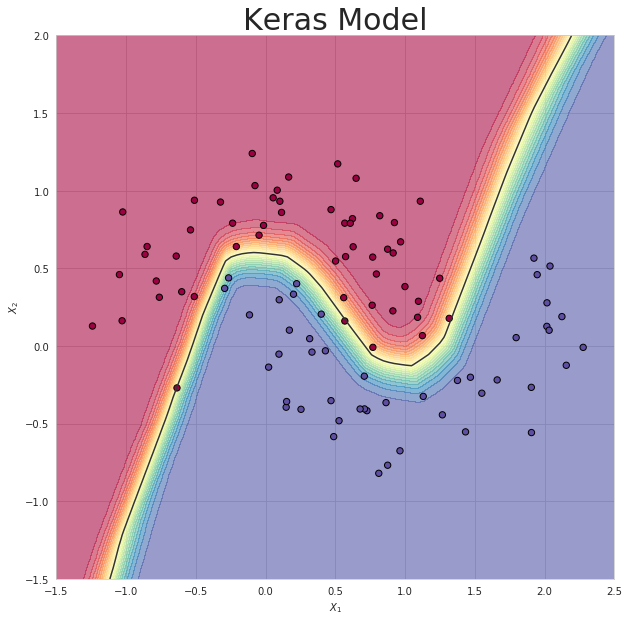

In [126]:
rediction_probs = model.predict_proba(grid_2d, batch_size=32, verbose=0)
make_plot(X_test, y_test, "Keras Model", file_name=None, XX=XX, YY=YY, preds=prediction_probs)

### NumPy Model

In [127]:
def callback_numpy_plot(index, params):
    plot_title = "NumPy Model - It: {:05}".format(index)
    file_name = "numpy_model_{}.png".format(index//50)
    file_path = os.path.join(OUTPUT_DIR, file_name)
    prediction_probs, _ = full_forward_propagation(np.transpose(grid_2d), params, NN_ARCHITECTURE)
    prediction_probs = prediction_probs.reshape(prediction_probs.shape[1], 1)
    make_plot(X_test, y_test, plot_title, file_name=file_path, XX=XX, YY=YY, preds=prediction_probs)

In [128]:
# Training
params_values = train(np.transpose(X_train), np.transpose(y_train.reshape((y_train.shape[0], 1))), NN_ARCHITECTURE, 10000, 0.01, callback_numpy_plot)

Iteration: 00000 - cost: 0.69365 - accuracy: 0.50444


/home/afghan/Dokumenty/REPOZYTORIA/ILearnDeepLearning.py/.env/lib/python3.5/site-packages/matplotlib/contour.py:1230: UserWarning: No contour levels were found within the data range.
  warnings.warn("No contour levels were found"


Iteration: 00050 - cost: 0.69349 - accuracy: 0.50444
Iteration: 00100 - cost: 0.69334 - accuracy: 0.50444
Iteration: 00150 - cost: 0.69319 - accuracy: 0.50444
Iteration: 00200 - cost: 0.69307 - accuracy: 0.50444
Iteration: 00250 - cost: 0.69295 - accuracy: 0.50444
Iteration: 00300 - cost: 0.69284 - accuracy: 0.50444
Iteration: 00350 - cost: 0.69272 - accuracy: 0.50444
Iteration: 00400 - cost: 0.69260 - accuracy: 0.50444
Iteration: 00450 - cost: 0.69249 - accuracy: 0.50444
Iteration: 00500 - cost: 0.69238 - accuracy: 0.50444
Iteration: 00550 - cost: 0.69228 - accuracy: 0.50444
Iteration: 00600 - cost: 0.69217 - accuracy: 0.50444
Iteration: 00650 - cost: 0.69206 - accuracy: 0.50444
Iteration: 00700 - cost: 0.69194 - accuracy: 0.50444
Iteration: 00750 - cost: 0.69182 - accuracy: 0.50444
Iteration: 00800 - cost: 0.69170 - accuracy: 0.50444
Iteration: 00850 - cost: 0.69156 - accuracy: 0.50444
Iteration: 00900 - cost: 0.69142 - accuracy: 0.50444
Iteration: 00950 - cost: 0.69126 - accuracy: 0

Iteration: 07800 - cost: 0.08647 - accuracy: 0.96778
Iteration: 07850 - cost: 0.08594 - accuracy: 0.96667
Iteration: 07900 - cost: 0.08544 - accuracy: 0.96667
Iteration: 07950 - cost: 0.08497 - accuracy: 0.96667
Iteration: 08000 - cost: 0.08453 - accuracy: 0.96556
Iteration: 08050 - cost: 0.08412 - accuracy: 0.96667
Iteration: 08100 - cost: 0.08371 - accuracy: 0.96667
Iteration: 08150 - cost: 0.08332 - accuracy: 0.96889
Iteration: 08200 - cost: 0.08295 - accuracy: 0.96889
Iteration: 08250 - cost: 0.08259 - accuracy: 0.96889
Iteration: 08300 - cost: 0.08219 - accuracy: 0.96889
Iteration: 08350 - cost: 0.08180 - accuracy: 0.96778
Iteration: 08400 - cost: 0.08145 - accuracy: 0.96778
Iteration: 08450 - cost: 0.08114 - accuracy: 0.96778
Iteration: 08500 - cost: 0.08084 - accuracy: 0.96889
Iteration: 08550 - cost: 0.08055 - accuracy: 0.96889
Iteration: 08600 - cost: 0.08025 - accuracy: 0.97000
Iteration: 08650 - cost: 0.07996 - accuracy: 0.97000
Iteration: 08700 - cost: 0.07968 - accuracy: 0

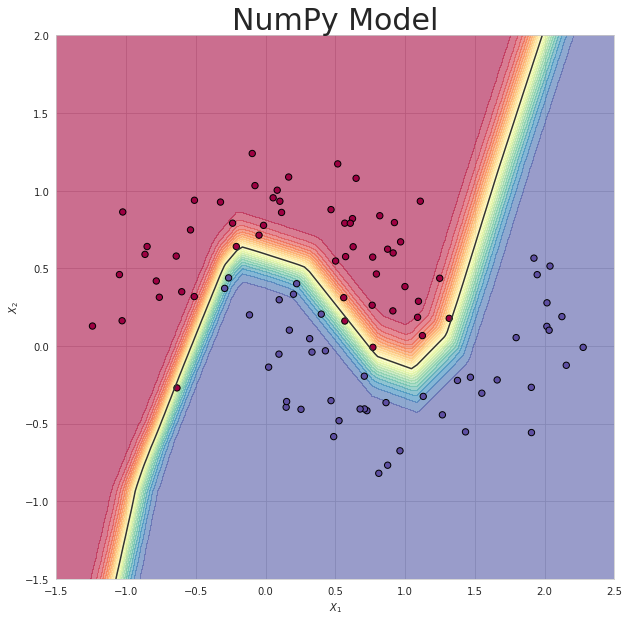

In [129]:
prediction_probs_numpy, _ = full_forward_propagation(np.transpose(grid_2d), params_values, NN_ARCHITECTURE)
prediction_probs_numpy = prediction_probs_numpy.reshape(prediction_probs_numpy.shape[1], 1)
make_plot(X_test, y_test, "NumPy Model", file_name=None, XX=XX, YY=YY, preds=prediction_probs_numpy)


## Thank you
---